In [114]:
import cv2
import os
from datetime import datetime
from pathlib import Path
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print(pd.__version__)


1.4.2


In [115]:
DATETIME_STR = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

FPS = 60

# Paths
TRAJECTORIES_CSV_DIR = Path("output/extracted_trajectories")
OUTPUT_BASE_DIR = Path("output/inspect_trajectory_hist")

EVENTS_CSV_HAS_HEADER = False
LABELS_CSV_HAS_HEADER = False

# Precision of the timestamp: for mikroseconds: 1000000, for milliseconds: 1000
TIMESTEPS_PER_SECOND = 1_000_000
# If timestamp in mikroseconds: -> mikroseconds per frame
TIMESTEPS_PER_FRAME = (1 / FPS) * TIMESTEPS_PER_SECOND
HALF_FRAME_TIME = TIMESTEPS_PER_FRAME // 2
T_SCALE = 0.002 # 0.002 is good
INV_T_SCALE = 1 / T_SCALE

T_BUCKET_WIDTH = 1000 * 100 # in us; 50 or 100ms is good?
BINS_PER_T_BUCKET = 250 # for the tx, ty projection: Sub-bins per bucket on the t axis

STAT_BINS_PER_T_BUCKET = 20
STAT_BIN_WIDTH = T_BUCKET_WIDTH / STAT_BINS_PER_T_BUCKET # in us

SAVE_IMAGE_DPI = 300

np.set_printoptions(suppress=True,precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)



In [129]:
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "3_classified/hauptsächlichBienen1_trajectories/9_bee_pts18648_start5289327.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "3_classified/hauptsächlichBienen1_trajectories/8_bee_pts11361_start4173946.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "3_classified/libellen1_trajectories/10_dra_pts22614_start39083346.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "3_classified/libellen1_trajectories/20_dra_pts83777_start103577662.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "3_classified/mb-dra1-1_trajectories/47_dra_pts70612_start45716670.csv"
# trajectory_filepath = TRAJECTORIES_CSV_DIR / "3_classified/3_m-h-h_trajectories/6_bee_pts40999_start15878090.csv"
trajectory_filepath = TRAJECTORIES_CSV_DIR / "3_classified/3_m-h-h_trajectories/13_bee_pts25416_start32130583.csv"

In [130]:
df_orig = pd.read_csv(trajectory_filepath, sep=',', header="infer")

df = df_orig.copy()
df = df[["x","y","t"]]
print(df.head())

   x    y     t
0  2  281 0.000
1  2  280 2.080
2  2  282 2.362
3  2  283 2.498
4  2  281 2.538


In [131]:
t_col_real = df.loc[:,"t"] * INV_T_SCALE
df["t_real"] = t_col_real.round().astype('Int64')
print(t_col_real[t_col_real < 0.0].head())

max_t = t_col_real.iloc[-1]
print("max_t", max_t)

max_t_str = f"{int((max_t / TIMESTEPS_PER_SECOND) // 60):0>2}m:{(max_t / TIMESTEPS_PER_SECOND % 60):0>2.2f}s"
print("max_t_str", max_t_str)


# Biene hat 200 flügelschläge pro sek. Das sind 5ms pro flügelschlag.
# Es sollen 10 Flügelschläge in ein Fenster passen. Also 5*10=50ms oder 50000us
number_of_buckets = int(np.ceil(max_t/T_BUCKET_WIDTH))

print("Die Bahn hat", number_of_buckets, "buckets von jeweils", T_BUCKET_WIDTH//1000, "ms")

t_col_buckets = t_col_real.floordiv(T_BUCKET_WIDTH).astype('Int64')
df["t_bucket"] = t_col_buckets

df["stat_bucket"]  = t_col_real.floordiv(STAT_BIN_WIDTH).astype('Int64')

print(len(df["stat_bucket"].unique()))


t_col_buckets = t_col_buckets[t_col_buckets!=-1]

event_counts_per_bucket = t_col_buckets.value_counts(sort=False).sort_index()
print(event_counts_per_bucket)
print(len(event_counts_per_bucket.index))

display(df)

Series([], Name: t, dtype: float64)
max_t 1441917.0000000002
max_t_str 00m:1.44s
Die Bahn hat 15 buckets von jeweils 100 ms
289
0      993
1     2386
2     2540
3     1966
4     1177
5      393
6     1427
7     1799
8     1989
9     2378
10    2060
11    2489
12    2194
13    1319
14     306
Name: t, dtype: Int64
15


,x,y,t,t_real,t_bucket,stat_bucket
0,2,281,0.000,0,0,0
1,2,280,2.080,1040,0,0
2,2,282,2.362,1181,0,0
3,2,283,2.498,1249,0,0
4,2,281,2.538,1269,0,0
...,...,...,...,...,...,...
25411,148,0,2882.734,1441367,14,288
25412,151,4,2883.146,1441573,14,288
25413,151,0,2883.252,1441626,14,288
25414,151,5,2883.292,1441646,14,288


t_bucket
0      993
1     2386
2     2540
3     1966
4     1177
5      393
6     1427
7     1799
8     1989
9     2378
10    2060
11    2489
12    2194
13    1319
14     306
dtype: int64

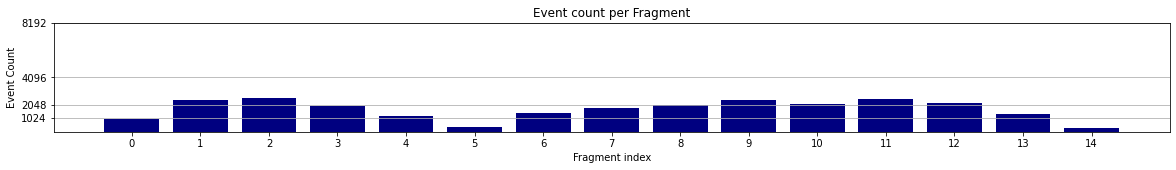

In [167]:
bs = df.groupby(["t_bucket"]).size()
display(bs)

xx = bs.index
yy = bs

fig = plt.figure(figsize = (20, 2))
 
# creating the bar plot
plt.bar(x=xx, height=yy, color='navy', width=0.8, align="center", tick_label=xx)

plt.title("Event count per Fragment")
plt.xlabel("Fragment index")
plt.ylabel("Event Count")
plt.yticks([2**10, 2**11, 2**12, 2**13])
plt.grid(axis="y")
plt.show()

In [133]:
bucket_inds = t_col_buckets.unique()
var_per_frag = {}

print("STD per Fragment")

for bi in bucket_inds:
    # each is a fragment
    bucket_df = df[df.t_bucket == bi]

    # V(X+Y)=V(X)+V(Y) ?
    std = bucket_df[["x","y"]].std(axis=0)
    sumvar = np.sum(std.to_numpy()).round()
    var_per_frag[bi] = sumvar
    print(bi, sumvar)

    


STD per Fragment
0 23.0
1 23.0
2 14.0
3 11.0
4 11.0
5 7.0
6 9.0
7 5.0
8 10.0
9 16.0
10 20.0
11 25.0
12 23.0
13 20.0
14 10.0


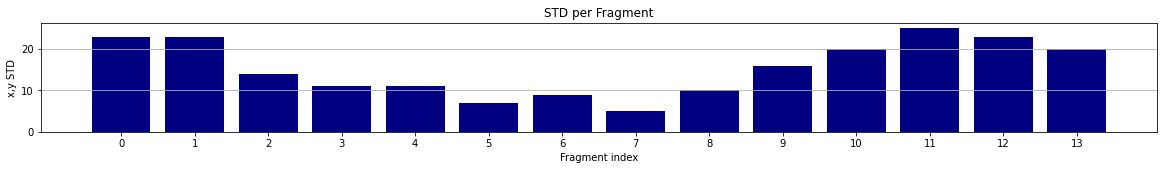

In [168]:
xx = np.arange(0, np.max(list(var_per_frag.keys())))
yy = [var_per_frag.get(x, 0) for x in xx]

fig = plt.figure(figsize = (20, 2))
 
# creating the bar plot
plt.bar(x=xx, height=yy, color='navy', width=0.8, align="center", tick_label=xx)
 
plt.xlabel("Fragment index")
plt.ylabel("x,y STD")
plt.title("STD per Fragment")
plt.grid(axis="y")
plt.show()


## STD von Teilfragmenten berechnen; Dann pro Fragment Mittelwert

In [187]:
# Calculate variance of parts of a fragment, then take avg per fragment

agg = {
    "x":"std",
    "y":"std",
    "t":"size"
}

df1 = df.groupby([df.t_bucket, df.stat_bucket]).agg(agg)
df1.rename(columns={"t":"event_count"}, inplace=True)
display("STD (x,y) per stat_bucket", df1)

# df1["std"] = df1[["x","y"]].sum(axis=1, min_count=1)
df1["std"] = df1[["x","y"]].mean(axis=1)
# df1["std"] = df1[["x","y"]].max(axis=1)
display("STD (x+y) per stat_bucket", df1)

agg1 = {
    "std":["mean","min"],
    "event_count":["sum"],
}

df1 = df1.groupby(level=0).agg(agg1)
df1.columns = df1.columns.get_level_values(1)
df1.rename(columns={"mean":"std_mean","min":"std_min","sum":"event_count"}, inplace=True)
display("mean STD per fragment over its subfragments", df1)


'STD (x,y) per stat_bucket'

x     y  event_count
t_bucket stat_bucket                         
0        0           0.681 1.542           20
         1           1.485 1.502           25
         2           2.463 2.249           30
         3           2.849 1.423           31
         4           1.444 1.664           37
...                    ...   ...          ...
14       284         3.150 2.952           26
         285         2.941 2.725           40
         286         2.956 3.194           32
         287         2.357 2.101           41
         288         1.301 1.847           27

[289 rows x 3 columns]

'STD (x+y) per stat_bucket'

x     y  event_count   std
t_bucket stat_bucket                               
0        0           0.681 1.542           20 1.111
         1           1.485 1.502           25 1.494
         2           2.463 2.249           30 2.356
         3           2.849 1.423           31 2.136
         4           1.444 1.664           37 1.554
...                    ...   ...          ...   ...
14       284         3.150 2.952           26 3.051
         285         2.941 2.725           40 2.833
         286         2.956 3.194           32 3.075
         287         2.357 2.101           41 2.229
         288         1.301 1.847           27 1.574

[289 rows x 4 columns]

'mean STD per fragment over its subfragments'

,std_mean,std_min,event_count
t_bucket,,,
0,2.161,1.111,993
1,2.852,2.520,2386
2,2.984,2.608,2540
3,2.498,2.203,1966
4,2.495,1.939,1177
5,2.874,2.298,393
6,2.491,2.082,1427
7,2.243,1.904,1799
8,3.007,2.573,1989


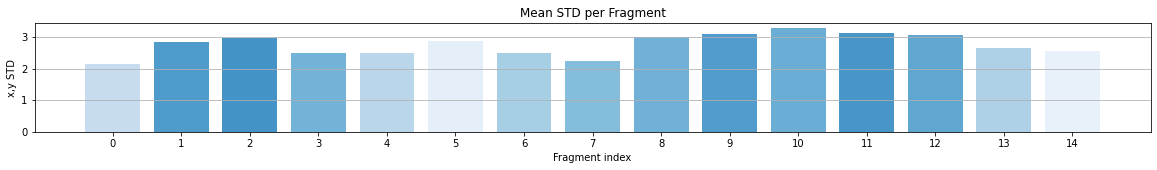

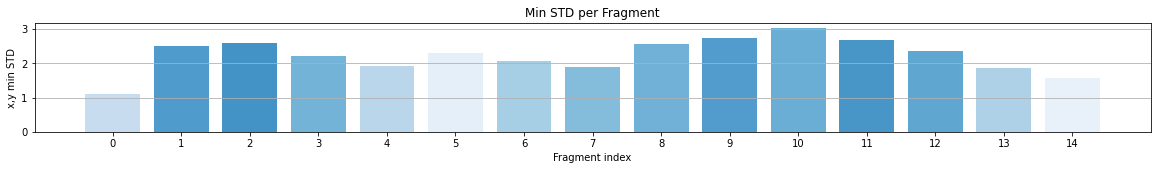

In [188]:
# Blues: light=low, saturated=high
cmap = plt.cm.get_cmap('Blues')

def event_count_to_color(n):
    MAXLOG = 12 # 13 = ld(8192)
    MAX = 2**MAXLOG
    n = min(MAX, n)
    # n = np.log2(n)
    # n = np.clip(n, 0, MAXLOG)
    return cmap(n/MAX)


colors = df1["event_count"].apply(event_count_to_color)
colors = colors.to_numpy()
colors = np.array([ *colors ])

# mean
xx = df1.index
yy = df1["std_mean"]

fig = plt.figure(figsize = (20, 2))
# creating the bar plot
plt.bar(x=xx, height=yy, color=colors, width=0.8, align="center", tick_label=xx)
plt.title("Mean STD per Fragment")
plt.xlabel("Fragment index")
plt.ylabel("x,y STD")
plt.grid(axis="y")
plt.show()

# min
xx = df1.index
yy = df1["std_min"]

fig = plt.figure(figsize = (20, 2))
# creating the bar plot
plt.bar(x=xx, height=yy, color=colors, width=0.8, align="center", tick_label=xx)
plt.title("Min STD per Fragment")
plt.xlabel("Fragment index")
plt.ylabel("x,y min STD")
plt.grid(axis="y")
plt.show()

## Bahnen begradigen

In [182]:
df2 = df

display(df2)

gt_200_inds = df.groupby([df.t_bucket]).count()["x"] > 200
display(gt_200_inds.tail())


,x,y,t,t_real,t_bucket,stat_bucket
0,2,281,0.000,0,0,0
1,2,280,2.080,1040,0,0
2,2,282,2.362,1181,0,0
3,2,283,2.498,1249,0,0
4,2,281,2.538,1269,0,0
...,...,...,...,...,...,...
25411,148,0,2882.734,1441367,14,288
25412,151,4,2883.146,1441573,14,288
25413,151,0,2883.252,1441626,14,288
25414,151,5,2883.292,1441646,14,288


t_bucket
10    True
11    True
12    True
13    True
14    True
Name: x, dtype: bool

In [183]:

agg = {
    "x":"mean",
    "y":"mean",
    "t":"count"
}

df2 = df.groupby([df.t_bucket, df.stat_bucket]).agg(agg).rename(columns={'t': 'stat_bucket_size'})
df2 = df2.reset_index("t_bucket")
display("mean (x,y) per stat_bucket", df2)


'mean (x,y) per stat_bucket'

,t_bucket,x,y,stat_bucket_size
stat_bucket,,,,
0,0,2.600,280.800,20
1,0,4.960,279.440,25
2,0,7.733,278.900,30
3,0,10.871,277.323,31
4,0,14.568,276.811,37
...,...,...,...,...
284,14,148.000,10.923,26
285,14,150.375,6.900,40
286,14,150.812,6.156,32


In [184]:
# df2['prev_x'] = df2['x'].shift(1)
# df2['next_x'] = df2['x'].shift(-1)
# df2['prev_y'] = df2['y'].shift(1)
# df2['next_y'] = df2['y'].shift(-1)

# df2

In [185]:
# df2['x2'] = df2['x'].rolling(window=3, center=True, min_periods=1).mean()
# df2


In [186]:
def weighted_mean(values, weights):
    """Compute weighted mean."""
    return (values * weights).sum() / weights.sum()

df2.rolling(2, min_periods=0, method="table").apply(lambda r: print(r), raw=True)


ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [ ]:
df3 = df
df3

,x,y,t,t_real,t_bucket,stat_bucket,stat_bucket_size
0,0,194,0.000,0,0,0,73.000
1,0,193,0.082,41,0,0,78.000
2,1,193,0.648,324,0,0,114.000
3,0,194,0.982,491,0,0,95.000
4,0,195,1.062,531,0,0,105.000
...,...,...,...,...,...,...,...
11356,697,90,5707.872,2853936,28,570,NaN
11357,696,90,5723.306,2861653,28,572,NaN
11358,700,89,5723.350,2861675,28,572,NaN
11359,697,91,5725.478,2862739,28,572,NaN
